# Monte Carlo Q-Learning

In [1]:
# Authors: 
# E. Pan - Imperial College

import pylab
import numpy as np
import scipy.integrate as scp
from pylab import *
import matplotlib.pyplot as plt
import csv
import os
import sys
import copy
import numpy.random as rnd
from scipy.spatial.distance import cdist
!pip install sobol_seq
import sobol_seq
from scipy.optimize import minimize
eps  = np.finfo(float).eps
import random
import time
matplotlib.rcParams['font.sans-serif'] = "helvetica"
matplotlib.rcParams['font.family'] = "helvetica"
from matplotlib.ticker import AutoMinorLocator
from IPython.display import Audio # Import sound alert dependencies
from IPython import display # For live plots
def Done():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))
# Insert whatever audio file you want above

You should consider upgrading via the 'pip install --upgrade pip' command.


## Dyanmical System

Here we have a dynamic system, where $x$ is biomas, $N$ is nitrogen source, and $F_{N_{in}}$ is an inflow rate.

$$\frac{\text{d}x}{\text{d}t}=\mu~x~\frac{N}{N+K_N}-\mu_d~x$$

$$\frac{\text{d}N}{\text{d}t}=-Y_{Nx}x~\mu~\frac{N}{N+K_N}+F_{N_{in}}$$

We wish to optimize at the final time $t_f$ the cost given by the biomass we can harves, minus a penalization for the nitrogen that was not consumed, the objective function is:

$$f_{obj_1}=100x_{t_f}-N_{t_f}$$

where $x_{t_f}$ and $N_{t_f}$ refer to the final biomass and nitrogen quantity. We can control $F_{N_{in}}\in[0,7]$ with a precision of $0.5$ changing it $10$ times (equidistantly) from time $0$ to time $t_f$

We can aditionally have an objective function that penalizes nitrogen source input:

$$f_{obj_2}=100x_{t_f}-N_{t_f}-\sum_{i=0}^{T}F_{N_{in}}^i$$

where $T$ is the total number of time steps (inputs) and $F_{N_{in}}^i$ corresponds to the nitrate input at time-step $i$.

## Dynamic Programming solutions

To solve this problem, initially we should think of discretizing states (time is already discretized). This can be done for Biomass in $0.5$ intervals, and for Nitrate in $25$ intervals. 

In [2]:
############ Defining Environment ##############

class Model_env: 
    
    # --- initializing model --- #
    def __init__(self, parameters, tf, modulus):
        
        # Object variable definitions
        self.parameters       = parameters
        self.tf, self.modulus = tf, modulus  # two column array [biomass nitrate]
        
    # --- dynamic model definition --- #    
    # model takes state and action of previous time step and integrates -- definition of ODE system at time, t
    def model(self, t, state):
        # internal definitions
        params = self.parameters
        FCn   = self.u0
                
        # state vector
        Cx  = state[0]
        Cn  = state[1]
        
        # parameters
        u_m  = params['u_m']; K_N  = params['K_N'];
        u_d  = params['u_d']; Y_nx = params['Y_nx'];
        
        # algebraic equations
        
        # variable rate equations
        dev_Cx  = u_m * Cx * Cn/(Cn+K_N) - u_d*Cx**2
        dev_Cn  = - Y_nx * u_m * Cx * Cn/(Cn+K_N) + FCn
        
        return np.array([dev_Cx, dev_Cn],dtype='float64')
    
    def discrete_env(self, state):
        # discretisation of the system, with introduction of stochasticity in terms of modulus
        modulus = self.modulus
        
        # passing to arrays
        modulus = np.array(modulus)    # eg. modulus = np.array([0.2, 20.]) basically what modulus does is it indicates the rounding of the conc of x and conc of nitrate
        state   = np.array(state)  # eg. state = np.array([0.1,150.0]) first number is the conc of x and 2nd number is the conc of nitrate

        resid = state % modulus 
        resid = resid/modulus # remember resid is now an array. resid is normalized with respect to the size of modulus 
        LB = resid.copy()
        UB = 1 - resid # 1 minus resid because we are talking about normalized inverse length
        draw = [0,0]
        for i in range(state.shape[0]):
            if LB[i] < UB[i]: #if lower bound distance is smaller (more likely to round down)
                LB[i] = LB[i]**3 #make distance even closer
                draw[i] = np.random.uniform(0,LB[i]+UB[i],1)
            elif LB[i] > UB[i]: # else upper bound distance is smaller (more liekly to round up)
                UB[i] = UB[i]**3
                draw[i] = np.random.uniform(0,LB[i]+UB[i],1)
            else:
                draw[i] = np.random.uniform(0,1,1)        
        for i in range(state.shape[0]):
            if draw[i] < UB[i]: #introduce stochasticity w.r.t. rounding up or down
                state[i] = state[i] - resid[i] * modulus[i] #rmb now resid is now a NORMALIZED array of 2 numbers so it has to be multiplied back to un-normalize residual #rounds down by substracting away the residual
            else:
                state[i] = state[i] - resid[i] * modulus[i] + modulus[i] #rounds up
        
        # fixes for representation 
        # Nitrate fix
        if state[1] < 0:
            state[1] = 0
        elif state[0] < 0:
            state[0] = 0
        
        # Biomass fix
        f = str(self.modulus[0])
        decimal = f[::-1].find('.')  
        state[0] = np.round(state[0], 2) # Changed the rounding to allow smaller x grid size
        # used to be: state[0] = np.round(state[0], decimal)
        f1 = str(self.modulus[1])
        decimal1 = f1[::-1].find('.')  
        state[0] = np.round(state[0], 2) # Changed the rounding to allow smaller x grid size
        # used to be: state[0] = np.round(state[0], decimal1)

        if state[0] == eps:
            state[0] = 0
        if state[1] == eps:
            state[1] = 0
        
        return state

    def simulation(self, x0, controls):
        # internal definitions
        model, tf     = self.model, self.tf
        self.controls = controls
        
        # initialize simulation
        current_state = x0
        
        # simulation #ONLY ONE STEP unlike the previous code shown above
        self.u0   = controls[:]                       # control for this step
        ode       = scp.ode(model)                      # define ode
        ode.set_integrator('lsoda', nsteps=3000)        # define integrator
        ode.set_initial_value(current_state, tf)         # set initial value
        current_state = list(ode.integrate(ode.t + tf)) # integrate system
        xt            = current_state                   # add current state Note: here we can add randomnes as: + RandomNormal noise
        
        return xt

    def MDP_simulation(self, x0, controls): #simulate ONLY ONE STEP
        xt          = self.simulation(x0, controls) #simulate
        xt_discrete = self.discrete_env(xt) # make output state discrete
        return xt_discrete

    def reward(self, state):
        reward = 100*state[-1][0] - state[-1][1]              # objective function 1
        return reward

In [3]:
modulus = [0.05  ,5.]
f = str(modulus[0])
decimal = f[::-1].find('.')  
# state[0] = np.round(state[0], decimal) 
# f1 = str(self.modulus[1])
# decimal1 = f1[::-1].find('.')  
# state[0] = np.round(state[0], decimal1)
decimal, np.round(1.05, decimal) 

(2, 1.05)

## Simulating one Step of the dynamic system as a MDP

In [4]:
# Creating the model
# p        = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49} # predetermined parameters by design
# tf       = 16.*24./10. # assuming 10 steps, we divide the whole horizon over 10 for one step
# x0       = np.array([0.2,700.0]) # initial state
# modulus  = [0.1, 60.] # basically what modulus does is it indicates the rounding of the conc of x and conc of nitrate
# u0       = np.array([7.]) #this is your CONTROL (rmb here it's only ONE STEP)

# MDP_BioEnv = Model_env(p, tf, modulus)
# MDP_BioEnv.MDP_simulation(x0, u0)

## Simulating multiple steps of the dynamic system as a MDP

In [5]:
steps_      = 10
FCn_0       = [np.sin(i/6.5)*2+5. for i in range(steps_)]
x0          = np.array([0.2,150]) # initial state
tf          = 16.*24./10.
x_list      = np.zeros((2,steps_+1)) #initialize state as 2D array where the 2 rows refer to conc of x and N.
t_list      = np.zeros((1,steps_+1)) #initialize time as 1D array
x_list[:,0] = x0
t_list[0]   = tf

for s in range(len(FCn_0)):
    MDP_BioEnv    = Model_env(p, tf, modulus)
    u0            = np.array([FCn_0[s]])
    x0            = MDP_BioEnv.MDP_simulation(x0, u0) #simulate one step, and update current state 
    tf            = tf + 16.*24./10. #increment time
    x_list[:,s+1] = x0 #update state memory
    t_list[:,s+1] = tf #update time memory

for i in range(x_list.shape[0]):
    plt.plot(t_list[0,:],x_list[i,:])
    plt.ylabel('state')
    plt.xlabel('time')
    plt.show()
plt.step(t_list[0,:-1],FCn_0)
plt.show()

NameError: name 'p' is not defined

In [6]:
x_list

array([[  0.2,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ],
       [150. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   0. ]])

## Initialize and describe system

In [7]:
p        = {'u_m' : 0.0923*0.62, 'K_N' : 393.10, 'u_d' : 0.01, 'Y_nx' : 504.49} # predetermined parameters by design
tf       = 16.*24./10. # assuming 10 steps, we divide the whole horizon over 10 for one step

modulus  = [0.01, 1.] # basically what modulus does is it indicates the rounding of the conc of x and conc of nitrate

Number_of_possible_x      = int(2.0/modulus[0]+1) #assumed max x value is 1.6
Number_of_possible_N      = int(700/modulus[1]+1) #assumed max N value is 400
Number_of_discrete_states = int(Number_of_possible_x * Number_of_possible_N)
max_increase_N = 7 # Maximum increase in N per time step
increment_N    = 1 # Spacing between increase in N
Number_of_possible_actions = int(max_increase_N/increment_N + 1)
Number_of_possible_times   = 11

MDP_BioEnv = Model_env(p, tf, modulus) # Initialize system

print('Number of discrete_states:', Number_of_discrete_states)
print('Shape of value table:', Number_of_possible_N , 'x', Number_of_possible_x)
print('Number of possible actions:', Number_of_possible_actions)
print('Number of possible times:', Number_of_possible_times)

Number of discrete_states: 140901
Shape of value table: 701 x 201
Number of possible actions: 8
Number of possible times: 11


In [8]:
# Dictionary to map action to actual increase in N
action_ID = [x for x in range(Number_of_possible_actions)]
increase_in_N = [x for x in np.arange(0,max_increase_N+increment_N,increment_N)]
action_ID_to_increase_in_N = dict(zip(action_ID,increase_in_N))
action_ID_to_increase_in_N #this dictionary maps action id to actual action itself (increase in N)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7}

In [9]:
def transition(state, action): # state can be described by tuple(x (algae conc), N (nitrate conc), time (in hours)), action can be described by FN ∈[0,7]
    '''arguments
       state: (x, N, t) tuple 
       action: int (0-14)
    
       outputs 
       new state: (x, N, t) tuple
       reward: int 
       '''
    state = np.array(state) 
    action = [action_ID_to_increase_in_N[action]] #assign action according to dictionary defined above
    
    if (abs(state[2] - 16.*24.) < 0.1): #check if terminal state is reached
        reward = (100 * state[0] - state[1])   #give reward when we LEAVE terminal state
        state[2]      += 16.*24./10. #increment time
        state_evolved = MDP_BioEnv.MDP_simulation(state[0:2], action) #evolve the system using ODE
        state_evolved = [round(state_evolved[0],2),round(state_evolved[1],1)]
        new_state = np.append(state_evolved,round(state[2],2)) # append time
        
    elif (state[2] > 16.*24.): #check if time is exceeded
        new_state = state #loop back to itself
        reward = 0 #and given zero reward    

    else: #else evolve the system and assign zero reward
        state[2]      += 16.*24./10. #increment time
        state_evolved = MDP_BioEnv.MDP_simulation(state[0:2], action) #evolve the system using ODE
        state_evolved = [round(state_evolved[0],2),round(state_evolved[1],1)]
        new_state = np.append(state_evolved,round(state[2],2)) # append time
        reward    = 0 # if terminal step not reached, reward = 0

    return tuple(new_state), reward

In [10]:
# Test transition function
for i in range(Number_of_possible_actions):
    print(transition((0.2,150,0),i))

((0.3, 87.0, 38.4), 0)
((0.32, 116.0, 38.4), 0)
((0.33, 146.0, 38.4), 0)
((0.35, 176.0, 38.4), 0)
((0.36, 206.0, 38.4), 0)
((0.38, 237.0, 38.4), 0)
((0.39, 268.0, 38.4), 0)
((0.41, 299.0, 38.4), 0)


## Simulate 1 episode

Current policy: [7, 2, 7, 3, 1, 0, 4, 6, 7, 2, 2]
Concentration of x: [0.2, 0.4, 0.72, 0.97, 0.99, 0.82, 0.65, 0.65, 0.81, 1.01, 0.96, 0.82]
Concentration of N: [150, 299.0, 152.0, 151.0, 58.0, 20.0, 3.0, 79.0, 131.0, 136.0, 41.0, 35.0]

Episode: [[(0.2, 150, 0), 7, 0], [(0.4, 299.0, 38.4), 2, 0], [(0.72, 152.0, 76.8), 7, 0], [(0.97, 151.0, 115.2), 3, 0], [(0.99, 58.0, 153.6), 1, 0], [(0.82, 20.0, 192.0), 0, 0], [(0.65, 3.0, 230.4), 4, 0], [(0.65, 79.0, 268.8), 6, 0], [(0.81, 131.0, 307.2), 7, 0], [(1.01, 136.0, 345.6), 2, 0], [(0.96, 41.0, 384.0), 2, 55.0]]
Score: 55.0


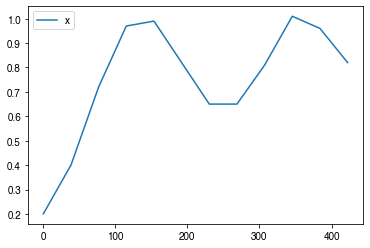

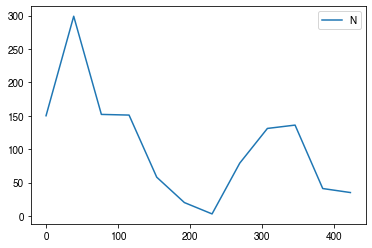

In [11]:
state = (0.2,150,0) # Initial state
x_data = [state[0]] # Store initial data 
N_data = [state[1]]
t_data = [state[2]]
my_policy = []
episode = [] # Initialize episode for saving S, A, R values as list of lists


for i in range(11): #take (10 + 1) steps
    old_state = state # Old state for storing into episode
    action = random.randint(0,Number_of_possible_actions - 1) # randint is end-exclusive
    state, reward  = transition(state, action) # Evolve to get new state 
    episode += [[old_state, action, reward]] # Update step
        
    my_policy += [action]
    x_data += [state[0]]
    N_data += [state[1]]
    t_data += [state[2]]
print('Current policy:', my_policy)
print('Concentration of x:', x_data)
print('Concentration of N:', N_data)
print('')
print('Episode:', episode)
score = transition((x_data[-2], N_data[-2],t_data[-2]),0)[1]
print('Score:', score)
def plot(t_data, x_data, N_data):
    plt.figure()
    plt.plot(t_data, x_data, label = 'x')
    plt.legend()
    plt.figure()
    plt.plot(t_data, N_data, label = 'N')
    plt.legend()
    
plot(t_data, x_data, N_data)

In [12]:
def take_random_action(epsilon): # epsilon represents the probability of taking a random action
    if np.random.uniform(0,1) < epsilon:
        return True
    else:
        return False

In [13]:
def generate_episode(Q_table, epsilon): 
    '''Generates an episode with the chosen action of each step having:
    Probability of epsilon       ---> random action
    Probability of (1 - epsilon) ---> greedy action (according to Q table)
    '''
    episode = []
    state = (0.2,150,0) # Initial state
    for i in range(11): #take (10 + 1) steps
        old_state = state # Old state for storing into episode
        if old_state not in Q_table.keys(): # If state has NOT been visited before
#             print('Unvisited')
            action = random.randint(0,Number_of_possible_actions - 1) # Choose random action
        else:                               # If state has been visited before
#             print('Visited')
            if take_random_action(epsilon): # Take random action
                action = random.randint(0,Number_of_possible_actions - 1)
            else:                           # Else take greedy action
                action = np.argmax(Q_table[old_state])
        
        state, reward  = transition(state, action) # Evolve to get new state 
        episode += [[old_state, action, reward]] # Update step
    return episode

In [14]:
def Update_Q_table(episode, Q_table):
    '''takes in an episode [[S0,A0,R1], [S1,A1,R2] .... ] --> a list of lists
    and a Q table
    and returns the updated Q table using incremental averaging
    '''
    Q_table['episode_count'] += 1 # Counter for num of episodes (for incremental average)
    for step in reversed(range(11)): # Episode has 11 entries, and Q table is updated in reversed order
        state, action, reward = episode[step]

        if step == 10: # If terminal state i.e. t = 384
            G = reward # Return = reward at terminal state
        else:
            G = reward + 0.9*G  # Return = reward + discounted return of the PREVIOUS state

        if state not in Q_table.keys(): # If state has not been visited before
#             print('Unvisited')
            Q_table[state] = []         # Initialize state entry in Q table
            for a in range(Number_of_possible_actions): # Iterate through all actions
                if a == action: # If the action is indeed taken
                    Q_table[state] += [G]
                else:
                    Q_table[state] += [-100000] # assign a default large negative value

        else:                          # Else state has been visited before
#             print('Visited')
            for a in range(Number_of_possible_actions):
                if Q_table[state][a] != -100000: # If this specific (s, a) has been updated before
                    Q_table[state][a] = Q_table[state][a] + 1/Q_table['episode_count']*(G - Q_table[state][a]) #Incremental average update
                elif Q_table[state][a] == -100000 and a == action: # If this state visited before but action not taken before
                    Q_table[state][a] = G
    return Q_table            

In [15]:
def score_q_table(Q_table, num_iterations):
    total_score = 0
    count = 0
    for j in range(num_iterations):
        state = (0.2,150,0) # Initial state
        try:
            for i in range(10): #take ten steps
                    action = np.argmax(Q_table[state])
                    state = transition(state, action)[0]
            score = 100*state[0] - state[1]
            count += 1
            total_score += score
        except:
            pass
    return total_score/count
# score_q_table(Q_table1, num_iterations = 5000)

## The method in the cell below **works**
Epsilon needs to be decayed gradually and exponentially

In [16]:
# %pylab qt

In [17]:
Q_table1 = {'episode_count': 0} # Initialize empty Q table as dictionary of list where INDEX corresponds to action

In [18]:
epsilon = 0.99     # Initialize epsilon

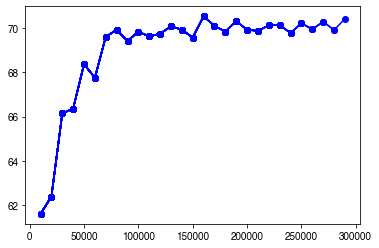

Average score over 5k episodes:  70.422
Average error between current Q table and previous Q table:  1.0383780035974149e-05

Episodes ran:  290100
Current epsilon:  0.054339612633507076
Average error between current Q table and previous Q table:  1.026615536546439e-05

Episodes ran:  290200
Current epsilon:  0.05428527302087357
Average error between current Q table and previous Q table:  1.1039208387783128e-05

Episodes ran:  290300
Current epsilon:  0.0542309877478527
Average error between current Q table and previous Q table:  1.0274177453752385e-05

Episodes ran:  290400
Current epsilon:  0.05417675676010485
Average error between current Q table and previous Q table:  1.0482027742217612e-05

Episodes ran:  290500
Current epsilon:  0.054122580003344745
Average error between current Q table and previous Q table:  1.915404973019323

Episodes ran:  290600
Current epsilon:  0.0540684574233414
Average error between current Q table and previous Q table:  1.0632005839540532e-05

Episodes ra

Episodes ran:  295800
Current epsilon:  0.05132741199721687
Average error between current Q table and previous Q table:  9.978860163390454e-06

Episodes ran:  295900
Current epsilon:  0.05127608458521965
Average error between current Q table and previous Q table:  1.0346326718025295e-05

Episodes ran:  296000
Current epsilon:  0.05122480850063443
Average error between current Q table and previous Q table:  1.9161300170118305

Episodes ran:  296100
Current epsilon:  0.051173583692133796
Average error between current Q table and previous Q table:  1.0366522112313626e-05

Episodes ran:  296200
Current epsilon:  0.051122410108441665
Average error between current Q table and previous Q table:  9.878045654762652e-06

Episodes ran:  296300
Current epsilon:  0.051071287698333225
Average error between current Q table and previous Q table:  1.048107726953033e-05

Episodes ran:  296400
Current epsilon:  0.051020216410634894
Average error between current Q table and previous Q table:  1.0393569524

TypeError: 'module' object is not callable

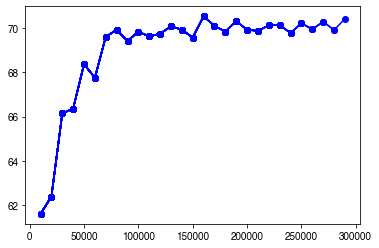

In [19]:
%%time

score_list = []     # Store scores vs number of episodes run
episode_list = []   # Store episodes at which scores are recorded
avg_error_list = [] # Avg error every 100 episodes
plt.ion() 

while True:
    Q_table_old = copy.deepcopy(Q_table1) # Save old Q table for comparison

    epsilon *= 0.999
    
    num_episodes = 100 # Number of episodes to run
    
    for i in range(num_episodes):
        episode1 = generate_episode(Q_table1, epsilon)
        Q_table1 = Update_Q_table(episode1, Q_table1)
    num_keys = len(Q_table_old)
    total_error = 0
    
    for key in Q_table_old.keys(): # Calculate average error
#         print(key)
        try:
            for j in range(Number_of_possible_actions):
#                 print(abs(Q_table1[key][j] - Q_table_old[key][j]))
                total_error += abs(Q_table1[key][j] - Q_table_old[key][j])
        except:
            pass
    avg_error = total_error/num_keys
    avg_error_list += [avg_error]
    
    print('Episodes ran: ', Q_table1['episode_count'])
    print('Current epsilon: ', epsilon)
    if Q_table1['episode_count'] in range(0, 3000000, 10000): # Score every x number of episodes
        try:
            score = score_q_table(Q_table1, num_iterations = 500)
            score_list += [score]
            episode_list += [Q_table1['episode_count']]
            plt.plot(episode_list,score_list, color = 'blue', marker = 'o')
#             plt.show()
            display.clear_output(wait=True)
            display.display(plt.gcf())
            print('Average score over 5k episodes: ', score)
        except:
             pass
    print('Average error between current Q table and previous Q table: ', avg_error)
    print('')
    
    if epsilon <= 0.05:
        break
Done()

In [ ]:
plt.plot(episode_list,score_list, color = 'blue', marker = 'o')

In [20]:
Q_table1

{'episode_count': 298500,
 (1.07, 97.0, 384.0): [-100000, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, -100000],
 (1.03, 103.0, 345.6): [69.28719786493478,
  59.40166679225615,
  49.507757772281174,
  40.51464297563154,
  29.726998318422837,
  19.83745978594609,
  9.067232775042916,
  -0.8371848960180682],
 (0.95, 101.0, 307.2): [-5.648858629269888,
  51.84019324427013,
  43.73512100691747,
  45.3609812076375,
  29.163755775553607,
  59.93459143796514,
  8.117843408115927,
  -100000],
 (0.93, 49.0, 268.8): [34.987171649111474,
  47.38478287691533,
  -9.461094607126824,
  42.279059918328755,
  36.4445430799434,
  35.70644047725001,
  7.2993030628697015,
  22.600283912451008],
 (1.04, 64.0, 230.4): [49.19844180927769,
  -0.644479178383633,
  43.95751063262736,
  6.583906591795376,
  15.74579144361019,
  -11.789742959312832,
  38.047618936477235,
  22.299982247560116],
 (1.09, 108.0, 192.0): [-100000,
  40.74151940223482,
  -100000,
  -100000,
  5.917842779101094,
  31.29599583369571,
  38.9703885

In [2]:
# Using pickle to store the Q_table as .p file
try:
    import cPickle as pickle
except ImportError:  # python 3.x
    import pickle

# with open('./Q_tables/Q_table_MC_v1.p', 'wb') as fp: # WRITE Q TABLE INTO .p file
#     pickle.dump(Q_table1, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open('./Q_tables/Q_table_MC_v1.p', 'rb') as fp: # LOAD Q TABLE INTO .p file
    Q_table2 = pickle.load(fp)
Q_table2

{'episode_count': 298500,
 (1.07, 97.0, 384.0): [-100000, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, -100000],
 (1.03, 103.0, 345.6): [69.28719786493478,
  59.40166679225615,
  49.507757772281174,
  40.51464297563154,
  29.726998318422837,
  19.83745978594609,
  9.067232775042916,
  -0.8371848960180682],
 (0.95, 101.0, 307.2): [-5.648858629269888,
  51.84019324427013,
  43.73512100691747,
  45.3609812076375,
  29.163755775553607,
  59.93459143796514,
  8.117843408115927,
  -100000],
 (0.93, 49.0, 268.8): [34.987171649111474,
  47.38478287691533,
  -9.461094607126824,
  42.279059918328755,
  36.4445430799434,
  35.70644047725001,
  7.2993030628697015,
  22.600283912451008],
 (1.04, 64.0, 230.4): [49.19844180927769,
  -0.644479178383633,
  43.95751063262736,
  6.583906591795376,
  15.74579144361019,
  -11.789742959312832,
  38.047618936477235,
  22.299982247560116],
 (1.09, 108.0, 192.0): [-100000,
  40.74151940223482,
  -100000,
  -100000,
  5.917842779101094,
  31.29599583369571,
  38.9703885

No handles with labels found to put in legend.


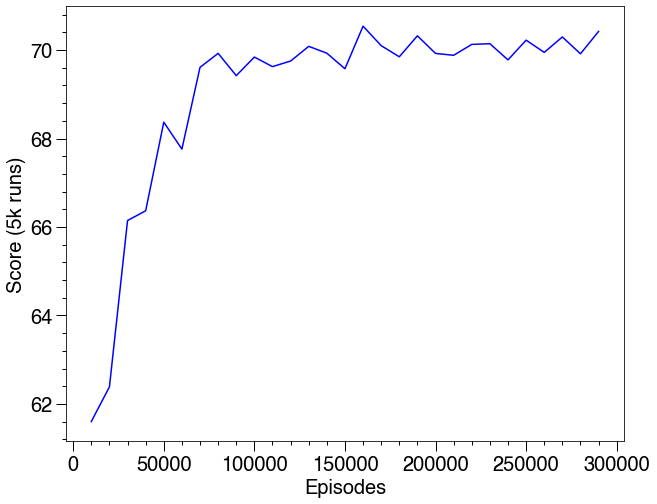

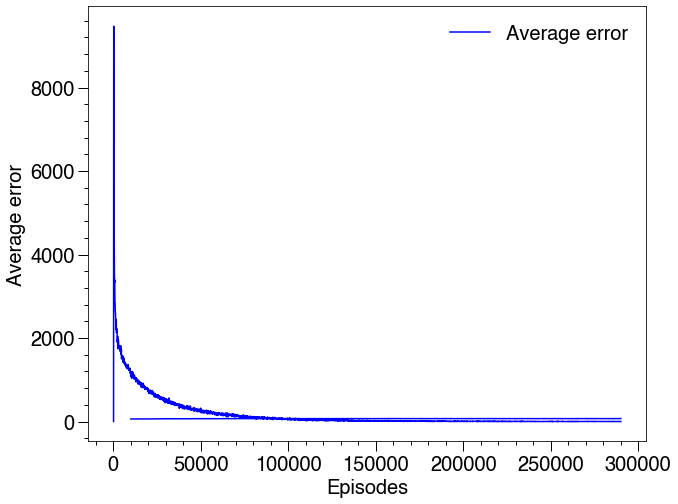

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', length=10, width=1, direction='out')
ax.tick_params(which='minor', length=4, width=1, direction='out')
plt.plot(episode_list,score_list, color = 'blue')
plt.legend(frameon = 0, fontsize = 20)
plt.ylabel('Score (5k runs)', fontsize = 20)
plt.xlabel('Episodes', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', length=10, width=1, direction='out')
ax.tick_params(which='minor', length=4, width=1, direction='out')
plt.plot(episode_list,score_list, color = 'blue')
plt.plot(np.linspace(100,episode_list[-1],len(avg_error_list)), avg_error_list, color = 'blue', label = 'Average error')
plt.legend(frameon =  0, fontsize = 20)
plt.ylabel('Average error', fontsize = 20)
plt.xlabel('Episodes', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

# Evaluation of Q table

Current policy: [7, 7, 0, 0, 7, 2, 6, 5, 6, 0]
Concentration of x: [0.2, 0.4, 0.83, 0.96, 0.74, 0.81, 0.85, 0.9, 0.97, 1.03, 0.85]
Concentration of N: [150, 299.0, 278.0, 35.0, 3.0, 130.0, 50.0, 107.0, 91.0, 101.0, 8.0]

Score: 77.0


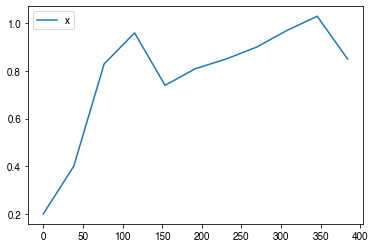

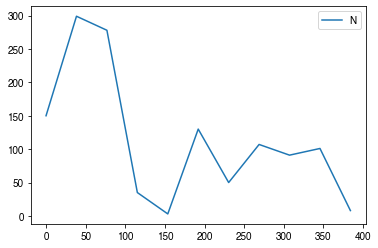

In [42]:
state = (0.2,150,0) # Initial state
x_data = [state[0]] # Store initial data
N_data = [state[1]]
t_data = [state[2]]
my_policy = []
for i in range(10): #take ten steps
        action = np.argmax(Q_table1[state])
        state = transition(state, action)[0]
        my_policy += [action]
        x_data += [state[0]]
        N_data += [state[1]]
        t_data += [state[2]]
print('Current policy:', my_policy)
print('Concentration of x:', x_data)
print('Concentration of N:', N_data)
print('')
score = 100*x_data[-1] - N_data[-1]
print('Score:', score)
def plot(t_data, x_data, N_data):
    plt.figure()
    plt.plot(t_data, x_data, label = 'x')
    plt.legend()
    plt.figure()
    plt.plot(t_data, N_data, label = 'N')
    plt.legend()
    
plot(t_data, x_data, N_data)

### Visualization of value of states in Q table
Disregards time dependency

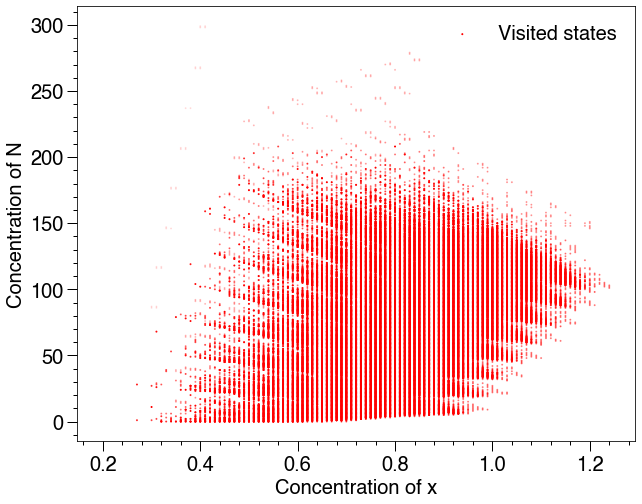

In [43]:
states_visited = list(Q_table1.keys())[1:] # States that were visited
x_visited = [] # Store visited values of x
N_visited = [] # and visited values of N
t_visited = [] # and visited values of t
# The above two lists will correspond to each other through indexing

for state in states_visited:
    x_visited += [state[0]] # Append x values
    N_visited += [state[1]] # and their corresponding N values
    t_visited += [state[2]] # and their corresponding t values

# For time resolution: use alpha
alphas = t_visited/max(t_visited) # Transparency: the darker it is, the later the time
rgba_colors = np.zeros((len(alphas),4))
rgba_colors[:,0] = 1.0 # For red the first column needs to be one
rgba_colors[:, 3] = alphas  # The fourth column needs to be your alphas
    
fig, ax = plt.subplots(figsize=(10,8))
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', length=10, width=1, direction='out')
ax.tick_params(which='minor', length=4, width=1, direction='out')
plt.scatter(x_visited, N_visited, color = rgba_colors, marker = 'o', s = 1, label = 'Visited states')
legend(frameon =  0, fontsize = 20)
ylabel('Concentration of N', fontsize = 20)
xlabel('Concentration of x', fontsize = 20)
xticks(fontsize = 20)
yticks(fontsize = 20)
show()

## Training the neural network for Q(s,a)
After a discrete Q function has been learned with the Monte-Carlo Q-learning above, the data in the Q table can now be used to train a neural network as a **starting point**.

In [4]:
Q_table2.pop('episode_count') # Remove episode count to not complicate data extraction
Q_table2

{(1.07, 97.0, 384.0): [-100000, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, -100000],
 (1.03, 103.0, 345.6): [69.28719786493478,
  59.40166679225615,
  49.507757772281174,
  40.51464297563154,
  29.726998318422837,
  19.83745978594609,
  9.067232775042916,
  -0.8371848960180682],
 (0.95, 101.0, 307.2): [-5.648858629269888,
  51.84019324427013,
  43.73512100691747,
  45.3609812076375,
  29.163755775553607,
  59.93459143796514,
  8.117843408115927,
  -100000],
 (0.93, 49.0, 268.8): [34.987171649111474,
  47.38478287691533,
  -9.461094607126824,
  42.279059918328755,
  36.4445430799434,
  35.70644047725001,
  7.2993030628697015,
  22.600283912451008],
 (1.04, 64.0, 230.4): [49.19844180927769,
  -0.644479178383633,
  43.95751063262736,
  6.583906591795376,
  15.74579144361019,
  -11.789742959312832,
  38.047618936477235,
  22.299982247560116],
 (1.09, 108.0, 192.0): [-100000,
  40.74151940223482,
  -100000,
  -100000,
  5.917842779101094,
  31.29599583369571,
  38.9703885236366,
  -100000],
 (1.07

In [6]:
# Extracting the data from the Q_table generated from MC Q-Learning

mydict = {}
for key in list(Q_table2.keys())[:100]:
    mydict[key] = Q_table2[key]
mydict

{(1.07, 97.0, 384.0): [-100000, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, -100000],
 (1.03, 103.0, 345.6): [69.28719786493478,
  59.40166679225615,
  49.507757772281174,
  40.51464297563154,
  29.726998318422837,
  19.83745978594609,
  9.067232775042916,
  -0.8371848960180682],
 (0.95, 101.0, 307.2): [-5.648858629269888,
  51.84019324427013,
  43.73512100691747,
  45.3609812076375,
  29.163755775553607,
  59.93459143796514,
  8.117843408115927,
  -100000],
 (0.93, 49.0, 268.8): [34.987171649111474,
  47.38478287691533,
  -9.461094607126824,
  42.279059918328755,
  36.4445430799434,
  35.70644047725001,
  7.2993030628697015,
  22.600283912451008],
 (1.04, 64.0, 230.4): [49.19844180927769,
  -0.644479178383633,
  43.95751063262736,
  6.583906591795376,
  15.74579144361019,
  -11.789742959312832,
  38.047618936477235,
  22.299982247560116],
 (1.09, 108.0, 192.0): [-100000,
  40.74151940223482,
  -100000,
  -100000,
  5.917842779101094,
  31.29599583369571,
  38.9703885236366,
  -100000],
 (1.07

### Testing with a small fraction of the actual q table

In [9]:
import torch
from IPython import display # for real time display
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import imageio
state_and_action = []
Q_value = []
for state in mydict.keys():
    action = 0 # Keep a counter for action
    for Q in mydict[state]:
        if Q != -100000:
            s_a = list(state)
            s_a.append(action)
            state_and_action += [s_a] # Save state and action pair
            Q_value += [Q] # Save Q value for that specific state and action pair
        action += 1  
state_and_action = torch.tensor(np.array(state_and_action)) # state and action tensor
Q_value = torch.tensor(np.array(Q_value)) #Q value tensor
print(state_and_action)
print(Q_value)

tensor([[  1.0700,  97.0000, 384.0000,   1.0000],
        [  1.0700,  97.0000, 384.0000,   2.0000],
        [  1.0700,  97.0000, 384.0000,   3.0000],
        ...,
        [  0.9000,  87.0000, 345.6000,   5.0000],
        [  0.9000,  87.0000, 345.6000,   6.0000],
        [  0.9000,  87.0000, 345.6000,   7.0000]], dtype=torch.float64)
tensor([ 1.0000e+01,  1.0000e+01,  1.0000e+01,  1.0000e+01,  1.0000e+01,
         1.0000e+01,  6.9287e+01,  5.9402e+01,  4.9508e+01,  4.0515e+01,
         2.9727e+01,  1.9837e+01,  9.0672e+00, -8.3718e-01, -5.6489e+00,
         5.1840e+01,  4.3735e+01,  4.5361e+01,  2.9164e+01,  5.9935e+01,
         8.1178e+00,  3.4987e+01,  4.7385e+01, -9.4611e+00,  4.2279e+01,
         3.6445e+01,  3.5706e+01,  7.2993e+00,  2.2600e+01,  4.9198e+01,
        -6.4448e-01,  4.3958e+01,  6.5839e+00,  1.5746e+01, -1.1790e+01,
         3.8048e+01,  2.2300e+01,  4.0742e+01,  5.9178e+00,  3.1296e+01,
         3.8970e+01, -4.7823e+00, -5.3112e+00,  2.7634e+01,  5.3147e+00,
        

In [10]:
torch_dataset = Data.TensorDataset(state_and_action, Q_value)
torch_dataset

In [ ]:
net = torch.nn.Sequential(
        torch.nn.Linear(4, 200), # 1 input node
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200, 1), # 1 output node
    )

optimizer = torch.optim.Adam(net.parameters(), lr=0.001) # Initialize Adam optimizer
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

BATCH_SIZE = 10 # Batch size per epoch
EPOCH = 1     # No. of epoch

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2,)

epoch_list = [] # save epoch for plotting
loss_list = [] # save loss for plotting

# start training
for epoch in range(EPOCH):
    epoch_list += [epoch]
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step

        prediction = net(batch_x.float())     # input x and predict based on x

        loss = loss_func(prediction, batch_y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step == 1:
            # plot and show learning process
            plt.cla()
#             ax.set_title('Regression Analysis - model 3 Batches', fontsize=35)
#             ax.set_xlabel('Independent variable', fontsize=24)
#             ax.set_ylabel('Dependent variable', fontsize=24)
#             ax.set_xlim(-11.0, 13.0)
#             ax.set_ylim(-1.1, 1.2)
#             ax.scatter(batch_x.data.numpy(), batch_y.data.numpy(), color = "blue", alpha=0.2)
#             ax.scatter(batch_x.data.numpy(), prediction.data.numpy(), color='green', alpha=0.5)
#             ax.text(8.8, -0.8, 'Epoch = %d' % epoch,
#                     fontdict={'size': 24, 'color':  'red'})
#             ax.text(8.8, -0.95, 'Loss = %.4f' % loss.data.numpy(),
#                     fontdict={'size': 24, 'color':  'red'})
            loss_list += [loss.data.numpy()]
            plt.plot(epoch_list, loss_list, label = 'Latest Loss = %.4f' % loss.data.numpy(), color = 'r')
            plt.xlabel('Epoch', fontsize = 20)
            plt.ylabel('Loss', fontsize = 20)
            plt.xticks(fontsize = 20)
            plt.yticks(fontsize = 20)
            plt.legend(fontsize = 20, frameon= 0)
            
            display.clear_output(wait=True) #these two lines plots the data in real time
            display.display(fig)